# Getting started with Advanced HPO Algorithms

:label:`sec_custom_advancedhpo`


## Loading libraries

In [1]:
# Basic utils for folder manipulations etc
import os
import shutil
import time
import re
import multiprocessing # to count the number of CPUs available

# External tools to load and process data
import openml
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# MXNet (NeuralNets)
import mxnet as mx
from mxnet import gluon, autograd
from mxnet.gluon import nn

# AutoGluon and HPO tools
import autogluon as ag

Check the version of MxNet, you should be fine with version >= 1.5

In [2]:
mx.__version__

'1.6.0'

You can also check the version of AutoGluon and the specific commit and check that it matches what you want.

In [3]:
ag.__version__

'0.0.11b20200614'

## Hyperparameter Optimization of a 2-layer MLP

### Setting up the context

Here
we declare a few "environment variables" setting the context for what we're
doing

In [4]:
OPENML_TASK_ID = 6                # describes the problem we will tackle
RATIO_TRAIN_VALID = 0.33          # split of the training data used for validation
RESOURCE_ATTR_NAME = 'epoch'      # how do we measure resources   (will become clearer further)
REWARD_ATTR_NAME = 'objective'    # how do we measure performance (will become clearer further)

NUM_CPUS = multiprocessing.cpu_count()

### Preparing the data

Set the openml directory to the current directory (next to the notebook) and download the task if the file is not already present.

In [5]:
openml.config.set_cache_directory("./")
task = openml.tasks.get_task(OPENML_TASK_ID)

Saved dataset 6: letter to file ./org/openml/www/datasets/6/dataset.pkl.py3


It's a multiclass classification task with 26 classes:

In [6]:
n_classes = len(task.class_labels)
n_classes

26

OpenML provides a standard train/test split that we can use.

In [7]:
train_indices, test_indices = task.get_train_test_split_indices()

X, y = task.get_X_and_y()

X.shape

Data pickle file already exists and is up to date.


(20000, 16)

Impute any missing value with a basic strategy and recover the training data

In [8]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X)

X_train = X[train_indices]
y_train = y[train_indices]

Resplit the training data into training+validation using the specific fraction indicated earlier

In [9]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(X_train, y_train, random_state=1, test_size=RATIO_TRAIN_VALID)

Standardize the data

In [10]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / (std + 1e-10)
X_valid = (X_valid - mean) / (std + 1e-10)

### Declaring a model specifying a hyperparameter space with AutoGluon

Two layer MLP where we optimize over:

- the number of units on the first layer
- the number of units on the second layer
- the dropout rate after each layer
- the learning rate
- the scaling
- the `@ag.args` decorator allows us to specify the space we will optimize over, this matches the [ConfigSpace](https://automl.github.io/ConfigSpace/master/) syntax

The body of the function `run_mlp_openml` is pretty simple:

- it reads the hyperparameters given via the decorator
- it defines a 2 layer MLP with dropout
- it declares a trainer with the 'adam' loss function and a provided learning rate
- it trains the NN with a number of epochs (most of that is boilerplate code from `mxnet`)
- the `reporter` at the end is used to keep track of training history in the hyperparameter optimization

**Note**: The number of epochs and the hyperparameter space are reduced to make for a shorter experiment

In [11]:
@ag.args(n_units_1=ag.space.Int(lower=16, upper=128),
         n_units_2=ag.space.Int(lower=16, upper=128),
         dropout_1=ag.space.Real(lower=0, upper=.75),
         dropout_2=ag.space.Real(lower=0, upper=.75),
         learning_rate=ag.space.Real(lower=1e-6, upper=1, log=True),
         batch_size=ag.space.Int(lower=8, upper=128),
         scale_1=ag.space.Real(lower=0.001, upper=10, log=True),
         scale_2=ag.space.Real(lower=0.001, upper=10, log=True),
         epochs=9)
def run_mlp_openml(args, reporter, **kwargs):
    # Time stamp for elapsed_time
    ts_start = time.time()
    # Unwrap hyperparameters
    n_units_1 = args.n_units_1
    n_units_2 = args.n_units_2
    dropout_1 = args.dropout_1
    dropout_2 = args.dropout_2
    scale_1 = args.scale_1
    scale_2 = args.scale_2
    batch_size = args.batch_size
    learning_rate = args.learning_rate

    ctx = mx.cpu()
    net = nn.Sequential()
    with net.name_scope():
        # Layer 1
        net.add(nn.Dense(n_units_1, activation='relu',
                         weight_initializer=mx.initializer.Uniform(scale=scale_1)))
        # Dropout
        net.add(gluon.nn.Dropout(dropout_1))
        # Layer 2
        net.add(nn.Dense(n_units_2, activation='relu',
                         weight_initializer=mx.initializer.Uniform(scale=scale_2)))
        # Dropout
        net.add(gluon.nn.Dropout(dropout_2))
        # Output
        net.add(nn.Dense(n_classes))
    net.initialize(ctx=ctx)

    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': learning_rate})

    for epoch in range(args.epochs):
        ts_epoch = time.time()

        train_iter = mx.io.NDArrayIter(
                        data={'data': X_train}, 
                        label={'label': y_train},
                        batch_size=batch_size, 
                        shuffle=True)
        valid_iter = mx.io.NDArrayIter(
                        data={'data': X_valid}, 
                        label={'label': y_valid},
                        batch_size=batch_size, 
                        shuffle=False)

        metric = mx.metric.Accuracy()
        loss = gluon.loss.SoftmaxCrossEntropyLoss()

        for batch in train_iter:
            data = batch.data[0].as_in_context(ctx)
            label = batch.label[0].as_in_context(ctx)
            with autograd.record():
                output = net(data)
                L = loss(output, label)
            L.backward()
            trainer.step(data.shape[0])
            metric.update([label], [output])

        name, train_acc = metric.get()

        metric = mx.metric.Accuracy()
        for batch in valid_iter:
            data = batch.data[0].as_in_context(ctx)
            label = batch.label[0].as_in_context(ctx)
            output = net(data)
            metric.update([label], [output])

        name, val_acc = metric.get()

        print('Epoch %d ; Time: %f ; Training: %s=%f ; Validation: %s=%f' % (
            epoch + 1, time.time() - ts_start, name, train_acc, name, val_acc))

        ts_now = time.time()
        eval_time = ts_now - ts_epoch
        elapsed_time = ts_now - ts_start

        # The resource reported back (as 'epoch') is the number of epochs
        # done, starting at 1
        reporter(
            epoch=epoch + 1, 
            objective=float(val_acc), 
            eval_time=eval_time,
            time_step=ts_now, 
            elapsed_time=elapsed_time)

**Note**: The annotation `epochs=9` specifies the maximum number of epochs for
training. It becomes available as `args.epochs`. Importantly, it is also
processed by `HyperbandScheduler` below in order to set its `max_t` attribute.

**Recommendation**: Whenever writing training code to be passed as `train_fn` to
a scheduler, if this training code reports a resource (or time) attribute, the
corresponding maximum resource value should be included in `train_fn.args`:

- If the resource attribute (`time_attr` of scheduler) in `train_fn` is `epoch`,
  make sure to include `epochs=XYZ` in the annotation. This allows the scheduler
  to read `max_t` from `train_fn.args.epochs`. This case corresponds to our
  example here.
- If the resource attribute is something else than `epoch`, you can also include
  the annotation `max_t=XYZ`, which allows the scheduler to read `max_t` from
  `train_fn.args.max_t`.

Annotating the training function by the correct value for `max_t` simplifies
scheduler creation (since `max_t` does not have to be passed), and avoids
inconsistencies between `train_fn` and the scheduler.


### Running the Hyperparameter Optimization

You can use the following schedulers:

- FIFO (`fifo`)
- Hyperband (either the stopping (`hbs`) or promotion (`hbp`) variant)

And the following searchers:

- Random search (`random`)
- Gaussian process based Bayesian optimization (`bayesopt`)
- SkOpt Bayesian optimization (`skopt`; only with FIFO scheduler)

Note that the method known as (asynchronous) Hyperband is using random search.
Combining Hyperband scheduling with the `bayesopt` searcher uses a novel
method called asynchronous BOHB.

Pick the combination you're interested in (doing the full experiment takes around
120 seconds, see the `time_out` parameter), running everything with multiple runs
can take a fair bit of time. In real life, you will want to choose a larger
`time_out` in order to obtain good performance.

In [12]:
SCHEDULER = "hbs"
SEARCHER = "bayesopt"

In [13]:
def compute_error(df):
    return 1.0 - df["objective"]

def compute_runtime(df, start_timestamp):
        return df["time_step"] - start_timestamp

def process_training_history(task_dicts, start_timestamp, 
                             runtime_fn=compute_runtime,
                             error_fn=compute_error):
    task_dfs = []
    for task_id in task_dicts:
        task_df = pd.DataFrame(task_dicts[task_id])
        task_df = task_df.assign(task_id=task_id,
                                 runtime=runtime_fn(task_df, start_timestamp),
                                 error=error_fn(task_df),
                                 target_epoch=task_df["epoch"].iloc[-1])
        task_dfs.append(task_df)

    result = pd.concat(task_dfs, axis="index", ignore_index=True, sort=True)
    # re-order by runtime
    result = result.sort_values(by="runtime")
    # calculate incumbent best -- the cumulative minimum of the error.
    result = result.assign(best=result["error"].cummin())
    return result

resources = dict(num_cpus=NUM_CPUS, num_gpus=0)

In [14]:
if SCHEDULER == 'fifo': 
    myscheduler = ag.scheduler.FIFOScheduler(
        run_mlp_openml,
        resource=resources,
        searcher=SEARCHER,
        time_out=120,
        time_attr=RESOURCE_ATTR_NAME,
        reward_attr=REWARD_ATTR_NAME)

else:
    # This setup uses rung levels at 1, 3, 9 epochs. We just use a single
    # bracket, so this is in fact successive halving (Hyperband would use
    # more than 1 bracket).
    # Also note that since we do not use the max_t argument of
    # HyperbandScheduler, this value is obtained from train_fn.args.epochs.
    sch_type = 'stopping' if SCHEDULER == 'hbs' else 'promotion'
    myscheduler = ag.scheduler.HyperbandScheduler(
        run_mlp_openml,
        resource=resources,
        searcher=SEARCHER,
        time_out=120,
        time_attr=RESOURCE_ATTR_NAME,
        reward_attr=REWARD_ATTR_NAME,
        type=sch_type,
        grace_period=1,
        reduction_factor=3,
        brackets=1)

# run tasks
myscheduler.run()
myscheduler.join_jobs()

results_df = process_training_history(
                myscheduler.training_history.copy(),
                start_timestamp=myscheduler._start_time)

max_t = 9, as inferred from train_fn.args
search_options: Key 'random_seed': Imputing default value 31415927
search_options: Key 'opt_skip_init_length': Imputing default value 150
search_options: Key 'opt_skip_period': Imputing default value 1
search_options: Key 'profiler': Imputing default value False
search_options: Key 'opt_maxiter': Imputing default value 50
search_options: Key 'opt_nstarts': Imputing default value 2
search_options: Key 'opt_warmstart': Imputing default value False
search_options: Key 'opt_verbose': Imputing default value False
search_options: Key 'opt_debug_writer': Imputing default value False
search_options: Key 'num_fantasy_samples': Imputing default value 20
search_options: Key 'num_init_random': Imputing default value 10
search_options: Key 'num_init_candidates': Imputing default value 250
search_options: Key 'initial_scoring': Imputing default value thompson_indep
search_options: Key 'first_is_default': Imputing default value True
search_options: Key 'debug

Epoch 1 ; Time: 0.595077 ; Training: accuracy=0.260079 ; Validation: accuracy=0.531250
Epoch 2 ; Time: 1.171749 ; Training: accuracy=0.496365 ; Validation: accuracy=0.655247
Epoch 3 ; Time: 1.740634 ; Training: accuracy=0.559650 ; Validation: accuracy=0.694686
Epoch 4 ; Time: 2.288682 ; Training: accuracy=0.588896 ; Validation: accuracy=0.711063
Epoch 5 ; Time: 2.838102 ; Training: accuracy=0.609385 ; Validation: accuracy=0.726939
Epoch 6 ; Time: 3.373529 ; Training: accuracy=0.628139 ; Validation: accuracy=0.745321
Epoch 7 ; Time: 3.924655 ; Training: accuracy=0.641193 ; Validation: accuracy=0.750501
Epoch 8 ; Time: 4.482823 ; Training: accuracy=0.653751 ; Validation: accuracy=0.763202
Epoch 9 ; Time: 5.051333 ; Training: accuracy=0.665482 ; Validation: accuracy=0.766043
Epoch 1 ; Time: 0.779395 ; Training: accuracy=0.048005 ; Validation: accuracy=0.111743
Epoch 1 ; Time: 0.325519 ; Training: accuracy=0.039835 ; Validation: accuracy=0.063967
Epoch 1 ; Time: 0.383138 ; Training: accura

Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.23636968]


Epoch 1 ; Time: 0.778011 ; Training: accuracy=0.384711 ; Validation: accuracy=0.618487
Epoch 2 ; Time: 1.510047 ; Training: accuracy=0.597190 ; Validation: accuracy=0.687899
Epoch 3 ; Time: 2.227235 ; Training: accuracy=0.654298 ; Validation: accuracy=0.749580


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.23636968]


Epoch 1 ; Time: 0.418063 ; Training: accuracy=0.242812 ; Validation: accuracy=0.544525
Epoch 2 ; Time: 0.836094 ; Training: accuracy=0.381196 ; Validation: accuracy=0.611940
Epoch 3 ; Time: 1.255888 ; Training: accuracy=0.424736 ; Validation: accuracy=0.645816


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.23636968]


Epoch 1 ; Time: 0.583567 ; Training: accuracy=0.490975 ; Validation: accuracy=0.697980
Epoch 2 ; Time: 1.159561 ; Training: accuracy=0.743997 ; Validation: accuracy=0.798822
Epoch 3 ; Time: 1.724998 ; Training: accuracy=0.811558 ; Validation: accuracy=0.832660
Epoch 4 ; Time: 2.309571 ; Training: accuracy=0.848982 ; Validation: accuracy=0.856566
Epoch 5 ; Time: 2.861516 ; Training: accuracy=0.879202 ; Validation: accuracy=0.878283
Epoch 6 ; Time: 3.452272 ; Training: accuracy=0.889303 ; Validation: accuracy=0.888047
Epoch 7 ; Time: 4.041467 ; Training: accuracy=0.904537 ; Validation: accuracy=0.893771
Epoch 8 ; Time: 4.639382 ; Training: accuracy=0.909588 ; Validation: accuracy=0.905051
Epoch 9 ; Time: 5.213415 ; Training: accuracy=0.921427 ; Validation: accuracy=0.910606


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.23636968]


Epoch 1 ; Time: 0.694321 ; Training: accuracy=0.067769 ; Validation: accuracy=0.159596


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.23636968]


Epoch 1 ; Time: 0.426386 ; Training: accuracy=0.424897 ; Validation: accuracy=0.649866
Epoch 2 ; Time: 0.876026 ; Training: accuracy=0.495782 ; Validation: accuracy=0.694556
Epoch 3 ; Time: 1.304327 ; Training: accuracy=0.516625 ; Validation: accuracy=0.685820


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.13630319]


Epoch 1 ; Time: 2.239761 ; Training: accuracy=0.553879 ; Validation: accuracy=0.784610
Epoch 2 ; Time: 4.478283 ; Training: accuracy=0.711124 ; Validation: accuracy=0.834005
Epoch 3 ; Time: 6.845206 ; Training: accuracy=0.753647 ; Validation: accuracy=0.850974
Epoch 4 ; Time: 9.141582 ; Training: accuracy=0.780587 ; Validation: accuracy=0.865087
Epoch 5 ; Time: 11.446277 ; Training: accuracy=0.795590 ; Validation: accuracy=0.886761
Epoch 6 ; Time: 13.779219 ; Training: accuracy=0.814324 ; Validation: accuracy=0.894657
Epoch 7 ; Time: 16.038917 ; Training: accuracy=0.819712 ; Validation: accuracy=0.899530
Epoch 8 ; Time: 18.339454 ; Training: accuracy=0.829244 ; Validation: accuracy=0.900538
Epoch 9 ; Time: 20.650641 ; Training: accuracy=0.834964 ; Validation: accuracy=0.906082


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.13630319]


Epoch 1 ; Time: 0.794149 ; Training: accuracy=0.518267 ; Validation: accuracy=0.774916
Epoch 2 ; Time: 1.617927 ; Training: accuracy=0.686890 ; Validation: accuracy=0.824080
Epoch 3 ; Time: 2.459448 ; Training: accuracy=0.725244 ; Validation: accuracy=0.833779
Epoch 4 ; Time: 3.406224 ; Training: accuracy=0.744503 ; Validation: accuracy=0.847993
Epoch 5 ; Time: 4.247401 ; Training: accuracy=0.757233 ; Validation: accuracy=0.853344
Epoch 6 ; Time: 5.042738 ; Training: accuracy=0.767565 ; Validation: accuracy=0.866890
Epoch 7 ; Time: 5.805382 ; Training: accuracy=0.772938 ; Validation: accuracy=0.873579
Epoch 8 ; Time: 6.648229 ; Training: accuracy=0.785088 ; Validation: accuracy=0.871070
Epoch 9 ; Time: 7.497322 ; Training: accuracy=0.778641 ; Validation: accuracy=0.879431


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.13630319]


Epoch 1 ; Time: 0.322368 ; Training: accuracy=0.578795 ; Validation: accuracy=0.775000
Epoch 2 ; Time: 0.664241 ; Training: accuracy=0.737789 ; Validation: accuracy=0.822833
Epoch 3 ; Time: 1.012690 ; Training: accuracy=0.784323 ; Validation: accuracy=0.853000
Epoch 4 ; Time: 1.388201 ; Training: accuracy=0.802723 ; Validation: accuracy=0.878000
Epoch 5 ; Time: 1.702730 ; Training: accuracy=0.818977 ; Validation: accuracy=0.879500
Epoch 6 ; Time: 2.015752 ; Training: accuracy=0.834323 ; Validation: accuracy=0.892500
Epoch 7 ; Time: 2.331300 ; Training: accuracy=0.841337 ; Validation: accuracy=0.905333
Epoch 8 ; Time: 2.702904 ; Training: accuracy=0.854703 ; Validation: accuracy=0.899333
Epoch 9 ; Time: 3.065227 ; Training: accuracy=0.856931 ; Validation: accuracy=0.903667


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.13630319]


Epoch 1 ; Time: 0.453346 ; Training: accuracy=0.531498 ; Validation: accuracy=0.747150
Epoch 2 ; Time: 0.920763 ; Training: accuracy=0.792328 ; Validation: accuracy=0.843058
Epoch 3 ; Time: 1.348128 ; Training: accuracy=0.850281 ; Validation: accuracy=0.869551
Epoch 4 ; Time: 1.782881 ; Training: accuracy=0.883102 ; Validation: accuracy=0.896546
Epoch 5 ; Time: 2.219829 ; Training: accuracy=0.903687 ; Validation: accuracy=0.904427
Epoch 6 ; Time: 2.670135 ; Training: accuracy=0.916832 ; Validation: accuracy=0.916499
Epoch 7 ; Time: 3.106123 ; Training: accuracy=0.923198 ; Validation: accuracy=0.922200
Epoch 8 ; Time: 3.539706 ; Training: accuracy=0.930638 ; Validation: accuracy=0.918511
Epoch 9 ; Time: 4.004550 ; Training: accuracy=0.938492 ; Validation: accuracy=0.930919


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.06908115]


Epoch 1 ; Time: 1.647548 ; Training: accuracy=0.433350 ; Validation: accuracy=0.677946


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.06908115]


Epoch 1 ; Time: 0.317426 ; Training: accuracy=0.287609 ; Validation: accuracy=0.607227


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.06908115]


Epoch 1 ; Time: 0.357903 ; Training: accuracy=0.304596 ; Validation: accuracy=0.557561


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.06908115]


Epoch 1 ; Time: 4.715902 ; Training: accuracy=0.505554 ; Validation: accuracy=0.732335
Epoch 2 ; Time: 9.728642 ; Training: accuracy=0.643153 ; Validation: accuracy=0.788863
Epoch 3 ; Time: 14.775184 ; Training: accuracy=0.678714 ; Validation: accuracy=0.815108


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.06908115]


Epoch 1 ; Time: 1.174318 ; Training: accuracy=0.045988 ; Validation: accuracy=0.068884


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.06908115]


Epoch 1 ; Time: 0.877352 ; Training: accuracy=0.599189 ; Validation: accuracy=0.779153
Epoch 2 ; Time: 1.755131 ; Training: accuracy=0.824299 ; Validation: accuracy=0.830350
Epoch 3 ; Time: 2.788160 ; Training: accuracy=0.876107 ; Validation: accuracy=0.876025
Epoch 4 ; Time: 3.816100 ; Training: accuracy=0.903170 ; Validation: accuracy=0.894429
Epoch 5 ; Time: 4.851447 ; Training: accuracy=0.918232 ; Validation: accuracy=0.917350
Epoch 6 ; Time: 5.929400 ; Training: accuracy=0.924439 ; Validation: accuracy=0.904300
Epoch 7 ; Time: 6.983368 ; Training: accuracy=0.934288 ; Validation: accuracy=0.927388
Epoch 8 ; Time: 8.082763 ; Training: accuracy=0.946619 ; Validation: accuracy=0.921031
Epoch 9 ; Time: 9.148064 ; Training: accuracy=0.952744 ; Validation: accuracy=0.929396


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.06908115]


Epoch 1 ; Time: 0.589238 ; Training: accuracy=0.618469 ; Validation: accuracy=0.732498
Epoch 2 ; Time: 1.157360 ; Training: accuracy=0.743800 ; Validation: accuracy=0.752715
Epoch 3 ; Time: 1.725213 ; Training: accuracy=0.770420 ; Validation: accuracy=0.741186


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.06908115]


Epoch 1 ; Time: 1.752632 ; Training: accuracy=0.538882 ; Validation: accuracy=0.739862
Epoch 2 ; Time: 3.661404 ; Training: accuracy=0.755859 ; Validation: accuracy=0.819788
Epoch 3 ; Time: 5.574539 ; Training: accuracy=0.820207 ; Validation: accuracy=0.846206
Epoch 4 ; Time: 7.484250 ; Training: accuracy=0.850021 ; Validation: accuracy=0.888440
Epoch 5 ; Time: 9.477233 ; Training: accuracy=0.870973 ; Validation: accuracy=0.886758
Epoch 6 ; Time: 11.510600 ; Training: accuracy=0.884720 ; Validation: accuracy=0.905771
Epoch 7 ; Time: 13.443718 ; Training: accuracy=0.891843 ; Validation: accuracy=0.917887
Epoch 8 ; Time: 15.410727 ; Training: accuracy=0.898882 ; Validation: accuracy=0.906781
Epoch 9 ; Time: 17.363517 ; Training: accuracy=0.906418 ; Validation: accuracy=0.926468


Fitting GP model
BO Algorithm: Generating initial candidates.
BO Algorithm: Scoring (and reordering) candidates.
BO Algorithm: Selecting final set of candidates.
Current best is [0.06908115]


Epoch 1 ; Time: 0.784555 ; Training: accuracy=0.533339 ; Validation: accuracy=0.728337
Epoch 2 ; Time: 1.574606 ; Training: accuracy=0.770801 ; Validation: accuracy=0.811141
Epoch 3 ; Time: 2.325537 ; Training: accuracy=0.837230 ; Validation: accuracy=0.848110
Epoch 4 ; Time: 3.113237 ; Training: accuracy=0.862513 ; Validation: accuracy=0.865005
Epoch 5 ; Time: 3.900196 ; Training: accuracy=0.884739 ; Validation: accuracy=0.869187
Epoch 6 ; Time: 4.607019 ; Training: accuracy=0.895976 ; Validation: accuracy=0.890097
Epoch 7 ; Time: 5.396503 ; Training: accuracy=0.908370 ; Validation: accuracy=0.902476
Epoch 8 ; Time: 6.149938 ; Training: accuracy=0.914401 ; Validation: accuracy=0.890264
Epoch 9 ; Time: 6.907515 ; Training: accuracy=0.924151 ; Validation: accuracy=0.910171


### Analysing the results

The training history is stored in the `results_df`, the main fields are the
runtime and `'best'` (the objective).

**Note**: You will get slightly different curves for different pairs of scheduler/searcher, the `time_out` here is a bit
too short to really see the difference in a significant way (it would be better
to set it to >1000s). Generally speaking though, hyperband stopping / promotion
+ model will tend to significantly outperform other combinations given enough time.

In [15]:
results_df.head()

,bracket,elapsed_time,epoch,error,eval_time,objective,runtime,searcher_data_size,searcher_params_kernel_covariance_scale,searcher_params_kernel_inv_bw0,...,searcher_params_kernel_inv_bw7,searcher_params_kernel_inv_bw8,searcher_params_mean_mean_value,searcher_params_noise_variance,target_epoch,task_id,time_since_start,time_step,time_this_iter,best
0,0,0.598014,1,0.468750,0.592961,0.531250,0.709945,NaN,1.0,1.0,...,1.0,1.0,0.0,0.001,9,0,0.712558,1.592113e+09,0.643653,0.468750
1,0,1.174040,2,0.344753,0.570004,0.655247,1.285971,1.0,1.0,1.0,...,1.0,1.0,0.0,0.001,9,0,1.287654,1.592113e+09,0.576003,0.344753
2,0,1.742718,3,0.305314,0.565562,0.694686,1.854649,1.0,1.0,1.0,...,1.0,1.0,0.0,0.001,9,0,1.856187,1.592113e+09,0.568677,0.305314
3,0,2.290722,4,0.288937,0.544203,0.711063,2.402653,2.0,1.0,1.0,...,1.0,1.0,0.0,0.001,9,0,2.403969,1.592113e+09,0.548004,0.288937
4,0,2.840082,5,0.273061,0.546539,0.726939,2.952013,2.0,1.0,1.0,...,1.0,1.0,0.0,0.001,9,0,2.953363,1.592113e+09,0.549361,0.273061


Text(0, 0.5, 'Objective')

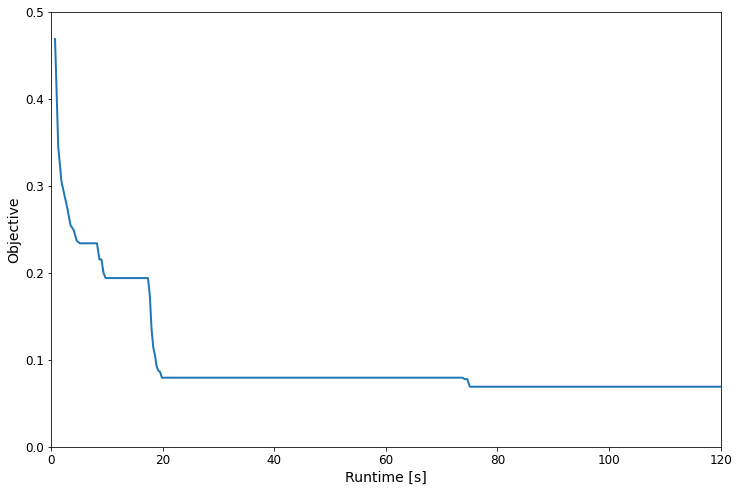

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

runtime = results_df['runtime'].values
objective = results_df['best'].values

plt.plot(runtime, objective, lw=2)
plt.xticks(fontsize=12)
plt.xlim(0, 120)
plt.ylim(0, 0.5)
plt.yticks(fontsize=12)
plt.xlabel("Runtime [s]", fontsize=14)
plt.ylabel("Objective", fontsize=14)

## Diving Deeper

Now, you are ready to try HPO on your own machine learning models (if you use
PyTorch, have a look at :ref:`sec_customstorch`). While AutoGluon comes with
well-chosen defaults, it can pay off to tune it to your specific needs. Here are
some tips which may come useful.

### Logging the Search Progress

First, it is a good idea in general to switch on `debug_log`, which outputs
useful information about the search progress:

In [17]:
myscheduler = ag.scheduler.FIFOScheduler(
    run_mlp_openml,
    resource=resources,
    searcher=SEARCHER,
    search_options={'debug_log': True},
    time_out=120,
    time_attr=RESOURCE_ATTR_NAME,
    reward_attr=REWARD_ATTR_NAME)

search_options: Key 'random_seed': Imputing default value 31415927
search_options: Key 'opt_skip_init_length': Imputing default value 150
search_options: Key 'opt_skip_period': Imputing default value 1
search_options: Key 'profiler': Imputing default value False
search_options: Key 'opt_maxiter': Imputing default value 50
search_options: Key 'opt_nstarts': Imputing default value 2
search_options: Key 'opt_warmstart': Imputing default value False
search_options: Key 'opt_verbose': Imputing default value False
search_options: Key 'opt_debug_writer': Imputing default value False
search_options: Key 'num_fantasy_samples': Imputing default value 20
search_options: Key 'num_init_random': Imputing default value 5
search_options: Key 'num_init_candidates': Imputing default value 250
search_options: Key 'initial_scoring': Imputing default value thompson_indep
search_options: Key 'first_is_default': Imputing default value True

[GPFIFOSearcher.__init__]
- acquisition_class = <class 'autogluon.se

The outputs show which configurations are chosen, stopped, or promoted. For
BO and BOHB, a range of information is displayed for every `get_config`
decision. This log output is very useful in order to figure out what is going
on during the search.

### Configuring `HyperbandScheduler`

The most important knobs to turn with `HyperbandScheduler` are `max_t`, `grace_period`,
`reduction_factor`, `brackets`, and `type`. The first three determine the rung
levels at which stopping or promotion decisions are being made.

- The maximum resource level `max_t` (usually, resource equates to epochs, so
   `max_t` is the maximum number of training epochs) is typically hardcoded in
   `train_fn` passed to the scheduler (this is `run_mlp_openml` in the example
   above). As already noted above, the value is best fixed in the `ag.args`
   decorator as `epochs=XYZ`, it can then be accessed as `args.epochs` in the
   `train_fn` code. If this is done, you do not have to pass `max_t` when creating
   the scheduler.
- `grace_period` and `reduction_factor` determine the rung levels, which are
   `grace_period`, `grace_period * reduction_factor`,
   `grace_period * (reduction_factor ** 2)`, etc. All rung levels must be less or
   equal than `max_t`. It is recommended to make `max_t` equal to the largest rung
   level. For example, if `grace_period = 1`, `reduction_factor = 3`, it is in
   general recommended to use `max_t = 9`, `max_t = 27`, or `max_t = 81`. Choosing
   a `max_t` value "off the grid" works against the successive halving principle
   that the total resources spent in a rung should be roughly equal between rungs. If in the
   example above, you set `max_t = 10`, about a third of configurations reaching
   9 epochs are allowed to proceed, but only for one more epoch.
- With `reduction_factor`, you tune the extent to which successive halving
   filtering is applied. The larger this integer, the fewer configurations make
   it to higher number of epochs. Values 2, 3, 4 are commonly used.
- Finally, `grace_period` should be set to the smallest resource (number of epochs)
   for which you expect any meaningful differentiation between configurations.
   While `grace_period = 1` should always be explored, it may be too low for any
   meaningful stopping decisions to be made at the first rung.
- `brackets` sets the maximum number of brackets in Hyperband (make sure to study
   the Hyperband paper or follow-ups for details). For `brackets = 1`, you are
   running successive halving (single bracket). Higher brackets have larger effective
   `grace_period` values (so runs are not stopped until later), yet are also chosen
   with less probability. We recommend to always consider successive halving
   (`brackets = 1`) in a comparison.
- Finally, with `type` (values `stopping`, `promotion`) you are choosing different
   ways of extending successive halving scheduling to the asynchronous
   case. The method for the default `stopping` is simpler and seems to perform well,
   but `promotion` is more careful promoting configurations to higher resource
   levels, which can work better in some cases.

### Asynchronous BOHB

Finally, here are some ideas for tuning asynchronous BOHB, apart from tuning its
`HyperbandScheduling` component. You need to pass these options in `search_options`.

- We support a range of different surrogate models over the criterion functions
   across resource levels. All of them are jointly dependent Gaussian process
   models, meaning that data collected at all resource levels are modelled
   together. The surrogate model is selected by `gp_resource_kernel`, values are
   `matern52`, `matern52-res-warp`, `exp-decay-sum`, `exp-decay-combined`,
   `exp-decay-delta1`. These are variants of either a joint Matern 5/2 kernel
   over configuration and resource, or the exponential decay model. Details about
   the latter can be found [here](https://arxiv.org/abs/2003.10865).
- Fitting a Gaussian process surrogate model to data encurs a cost which scales
   cubically with the number of datapoints. When applied to expensive deep learning
   workloads, even multi-fidelity asynchronous BOHB is rarely running up more than
   100 observations or so (across all rung levels and brackets), and the GP
   computations are subdominant. However, if you apply it to cheaper `train_fn`
   and find yourself beyond 2000 total evaluations, the cost of GP fitting can
   become painful. In such a situation, you can explore the options `opt_skip_period`
   and `opt_skip_num_max_resource`. The basic idea is as follows. By far the most
   expensive part of a `get_config` call (picking the next configuration) is the
   refitting of the GP model to past data (this entails re-optimizing hyperparameters
   of the surrogate model itself). The options allow you to skip this expensive
   step for most `get_config` calls, after some initial period. Check the docstrings
   for details about these options. If you find yourself in such a situation and
   gain experience with these skipping features, make sure to contact the AutoGluon
   developers -- we would love to learn about your use case.